In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn import svm, neighbors, ensemble, feature_selection
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from torch.utils.data import Dataset, DataLoader
df = pd.read_csv('dataset_phishing.csv')

In [2]:
df = df[['url', 'status']]

In [3]:
df.head()

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [4]:
df[df['status'] == 'phishing']

,url,status
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
5,http://appleid.apple.com-app.es/,phishing
7,http://www.shadetreetechnology.com/V4/validati...,phishing
13,http://html.house/l7ceeid6.html,phishing
...,...,...
11418,http://www.heinzreber.net/homeflash1.html,phishing
11421,http://www.peoplemakingplaces.com/includes/Sup...,phishing
11423,http://www.dmega.co.kr/dmega/data/qna/sec/page...,phishing
11426,http://www.budgetbots.com/server.php/Server%20...,phishing


In [5]:
from urllib.parse import urlparse
import tldextract
import re

def extract_features(features, url):
    
    # Basic length features
    features['url_length'] = len(url)
    features['num_dots'] = url.count('.')
    features['num_hyphens'] = url.count('-')
    features['num_underscore'] = url.count('_')
    features['num_slash'] = url.count('/')
    features['num_questionmark'] = url.count('?')
    features['num_equal'] = url.count('=')
    features['num_at'] = url.count('@')
    features['num_and'] = url.count('&')
    features['num_exclamation'] = url.count('!')
    features['num_space'] = url.count(' ')
    features['num_tilde'] = url.count('~')
    features['num_comma'] = url.count(',')
    features['num_plus'] = url.count('+')
    features['num_asterisk'] = url.count('*')
    features['num_hash'] = url.count('#')
    features['num_dollar'] = url.count('$')
    features['num_percent'] = url.count('%')
    
    # URL breakdown using urllib
    parsed = urlparse(url)
    ext = tldextract.extract(url)
    
    # Domain features
    features['domain_length'] = len(parsed.netloc)
    features['num_subdomains'] = ext.subdomain.count('.') + 1 if ext.subdomain else 0
    features['domain_has_ip'] = 1 if re.match(r'^\d+\.\d+\.\d+\.\d+$', ext.domain) else 0
    features['is_https'] = 1 if parsed.scheme == 'https' else 0
    features['tld'] = ext.suffix
    
    # Path features
    features['path_length'] = len(parsed.path)
    features['num_params'] = parsed.query.count('&') + 1 if parsed.query else 0
    features['file_extension'] = parsed.path.split('.')[-1] if '.' in parsed.path else 'none'
    
    return features

In [6]:
import re
from urllib.parse import urlparse

# IPv4 pattern (matches 0.0.0.0 to 255.255.255.255)
IPV4_PATTERN = r'^((25[0-5]|2[0-4]\d|1\d{2}|[1-9]?\d)\.){3}(25[0-5]|2[0-4]\d|1\d{2}|[1-9]?\d)$'

# IPv6 pattern (simplified version)
IPV6_PATTERN = r'^([0-9a-fA-F]{1,4}:){7}[0-9a-fA-F]{1,4}$'

In [7]:
def is_ip_url(url):
    """Returns True if URL contains IP address instead of domain name"""
    parsed = urlparse(url)
    
    # Check entire URL for IP patterns 
    full_url_check = re.search(
        r'(?:\d{1,3}\.){3}\d{1,3}|\[[0-9a-fA-F:]+\]', 
        url, 
        flags=re.IGNORECASE
    )
    
    # Check if path contains IP
    path_has_ip = any(
        re.match(IPV4_PATTERN, part) or re.match(IPV6_PATTERN, part)
        for part in parsed.path.split('/')
    )
    
    return path_has_ip or bool(full_url_check)

In [8]:
import re

def add_advanced_features(features, url):
    parsed = urlparse(url)
    ext = tldextract.extract(url)
    # Suspicious patterns
    features['has_port'] = 1 if ':' in parsed.netloc else 0
    features['double_slash'] = 1 if '//' in parsed.path else 0
    features['phishy_words'] = sum(url.lower().count(w) for w in ['login', 'signin', 'verify', 'secure', 'update', 'banking'])
    
    # URL shortening services
    shorteners = ['bit.ly', 'goo.gl', 'tinyurl', 'ow.ly', 't.co']
    features['is_shortened'] = 1 if any(s in parsed.netloc for s in shorteners) else 0
    
    # Numeric features
    features['num_digits'] = sum(c.isdigit() for c in url)
    features['domain_num_digits'] = sum(c.isdigit() for c in ext.domain)
    
    # Redirection features
    features['redirect_http'] = 1 if url.startswith('http://') and 'https://' in url else 0
    
    # Special TLDs
    features['suspicious_tld'] = 1 if ext.suffix in ['xyz', 'top', 'loan', 'tk', 'ml'] else 0

    # Depth of path
    features['path_depth'] = parsed.path.count('/')

    # Suspicious file extensions
    features['exe_extension'] = 1 if parsed.path.endswith('.exe') else 0

    # IP address in url
    features['is_ip'] = is_ip_url(url)
    
    return features

In [9]:

def full_feature_extraction(df):
    feature_list = []

    for i in df.values:
        url = i[0]
        status = i[1]
        features = {}
        features['url'] = url
        features['status'] = status
        features = extract_features(features, url)
        features = add_advanced_features(features, url)
        feature_list.append(features)
    
    return pd.DataFrame(feature_list)

In [10]:
data = full_feature_extraction(df)

In [11]:
data.columns

Index(['url', 'status', 'url_length', 'num_dots', 'num_hyphens',
       'num_underscore', 'num_slash', 'num_questionmark', 'num_equal',
       'num_at', 'num_and', 'num_exclamation', 'num_space', 'num_tilde',
       'num_comma', 'num_plus', 'num_asterisk', 'num_hash', 'num_dollar',
       'num_percent', 'domain_length', 'num_subdomains', 'domain_has_ip',
       'is_https', 'tld', 'path_length', 'num_params', 'file_extension',
       'has_port', 'double_slash', 'phishy_words', 'is_shortened',
       'num_digits', 'domain_num_digits', 'redirect_http', 'suspicious_tld',
       'path_depth', 'exe_extension', 'is_ip'],
      dtype='object')

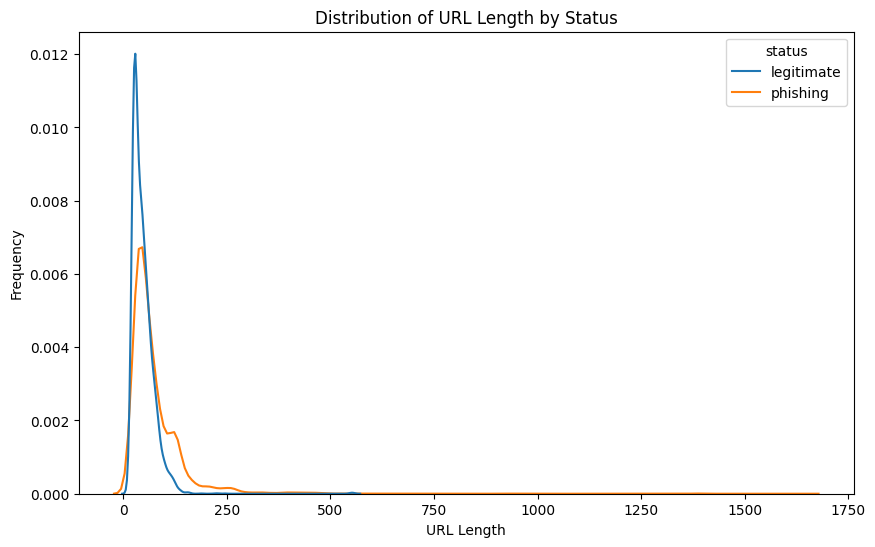

In [12]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='url_length', hue='status')
plt.title("Distribution of URL Length by Status")
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.show()

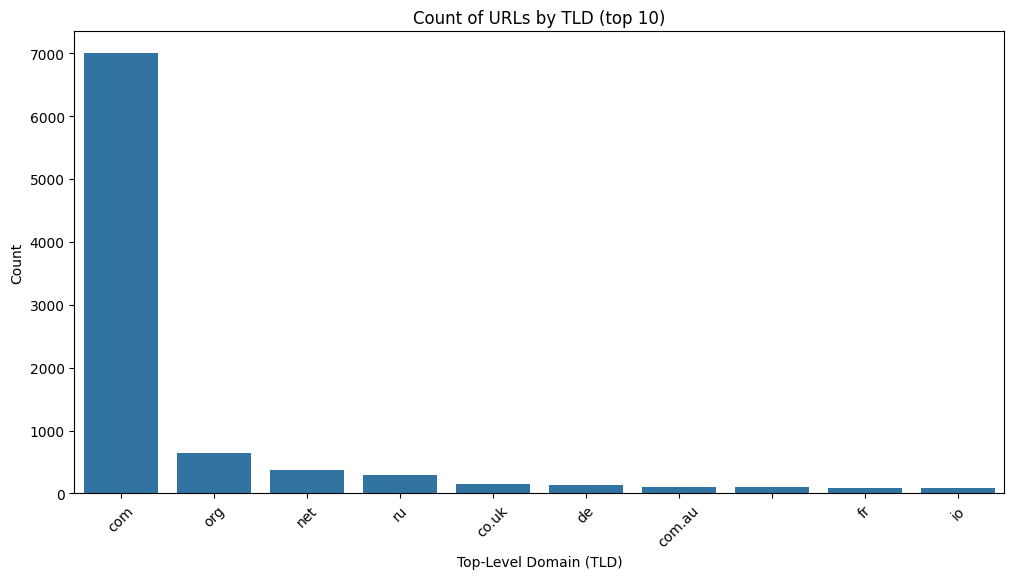

In [13]:
plt.figure(figsize=(12, 6))
order = data['tld'].value_counts()[:10].index
sns.countplot(data=data, x='tld', order=order)
plt.title("Count of URLs by TLD (top 10)")
plt.xlabel("Top-Level Domain (TLD)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

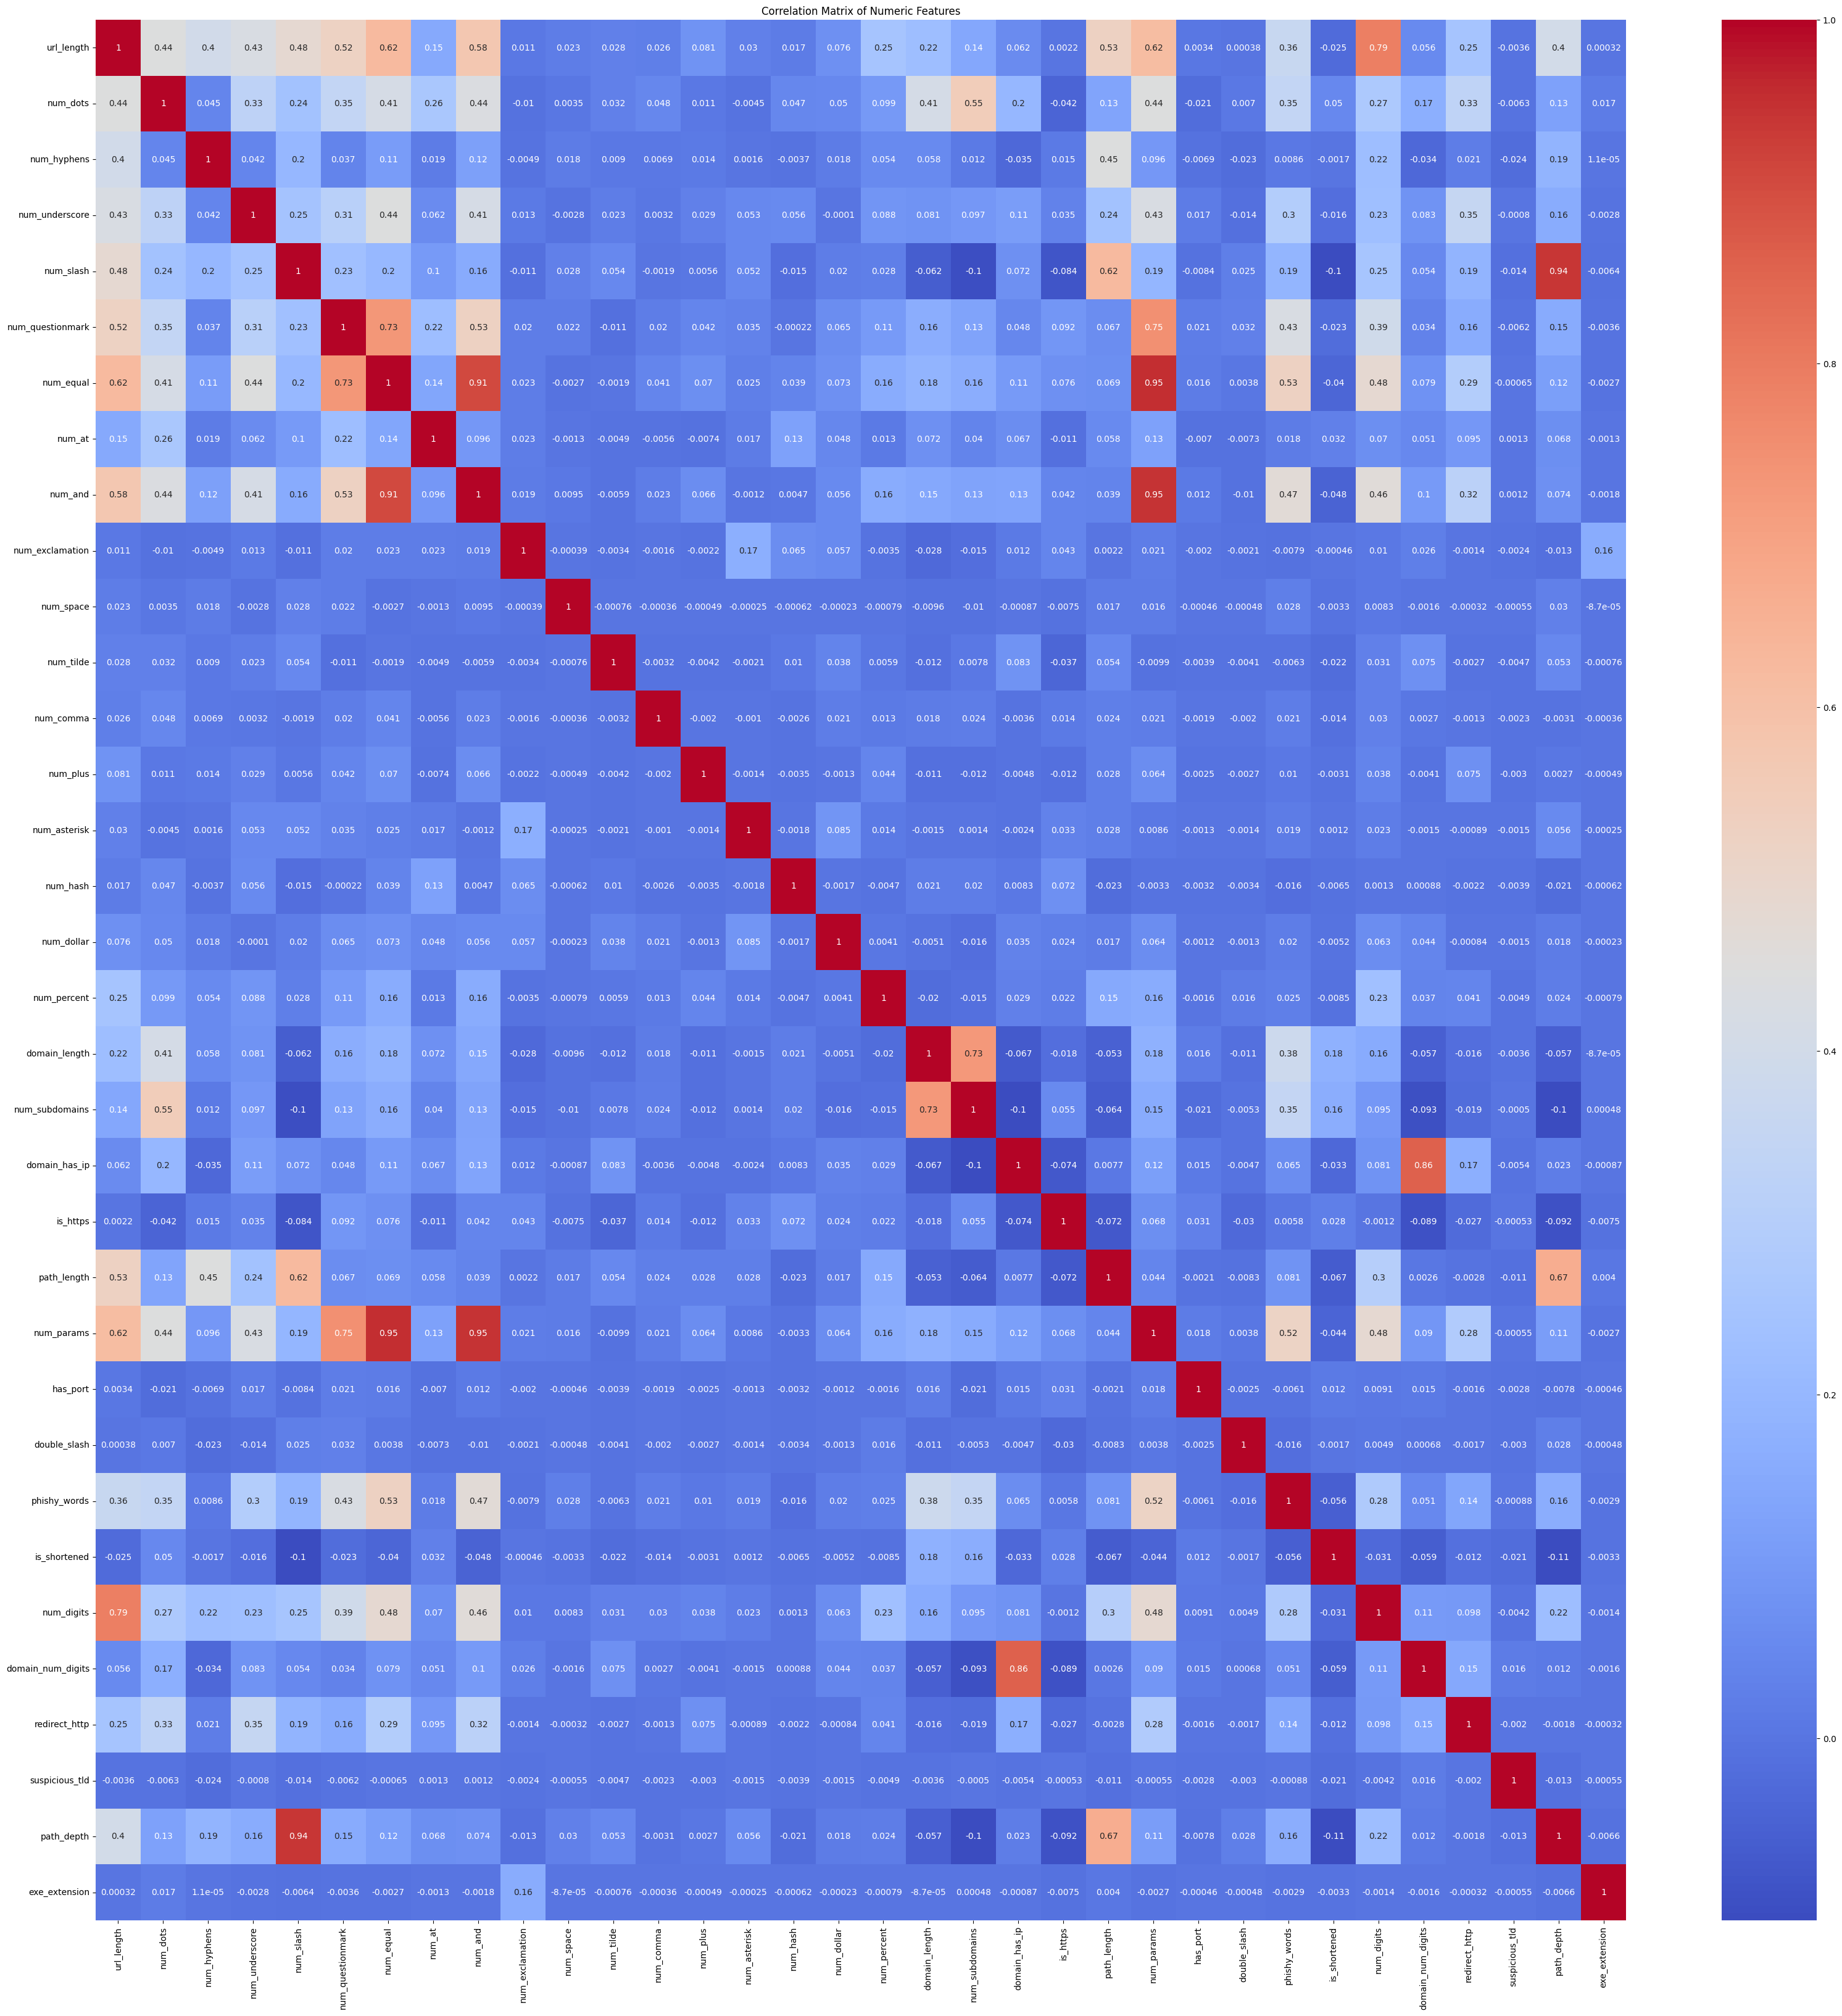

In [14]:
numeric_cols = [col for col in data.columns if data[col].dtype in ['int64', 'float64'] and col not in ['status']]
corr = data[numeric_cols].corr()
plt.figure(figsize=(40, 40))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

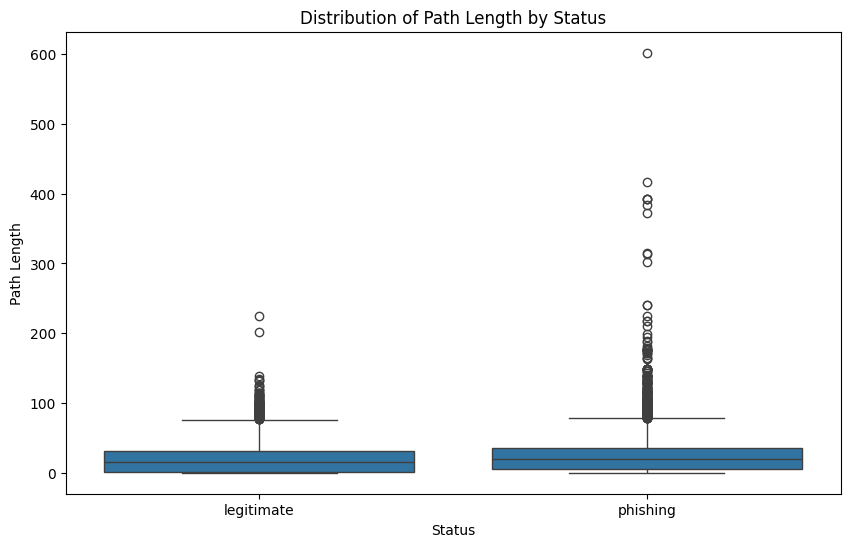

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='status', y='path_length')
plt.title("Distribution of Path Length by Status")
plt.xlabel("Status")
plt.ylabel("Path Length")
plt.show()

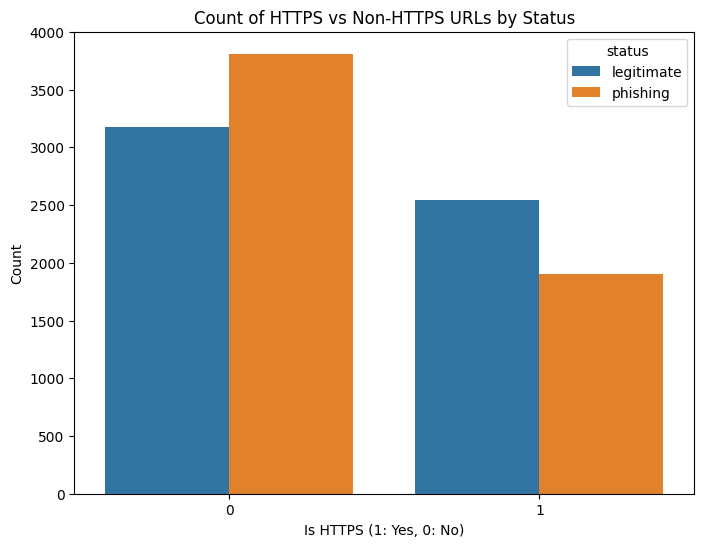

In [16]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='is_https', hue='status')
plt.title("Count of HTTPS vs Non-HTTPS URLs by Status")
plt.xlabel("Is HTTPS (1: Yes, 0: No)")
plt.ylabel("Count")
plt.show()

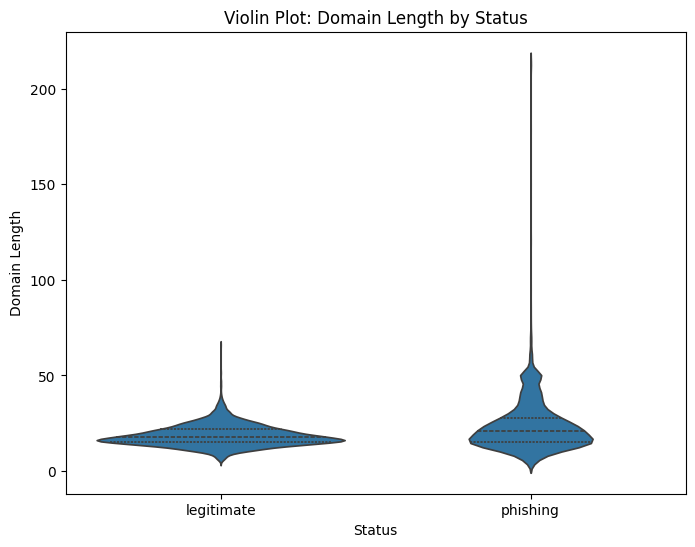

In [17]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=data, x='status', y='domain_length', inner='quartile')
plt.title("Violin Plot: Domain Length by Status")
plt.xlabel("Status")
plt.ylabel("Domain Length")
plt.show()

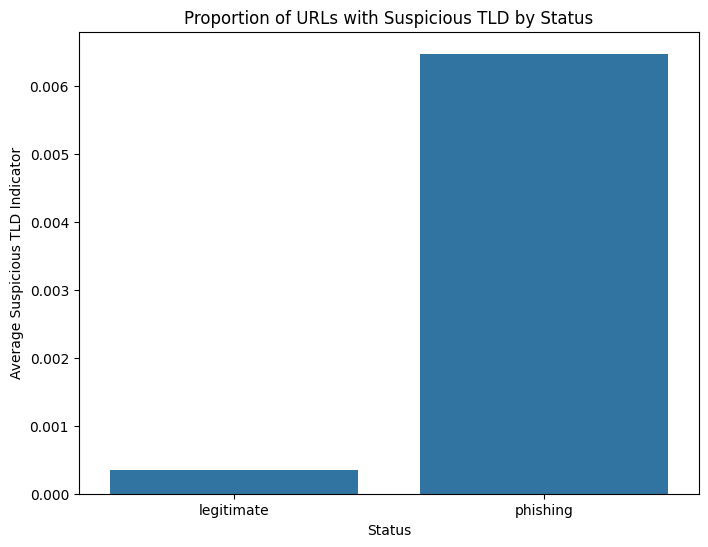

In [18]:
tld_suspicious = data.groupby('status')['suspicious_tld'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(data=tld_suspicious, x='status', y='suspicious_tld')
plt.title("Proportion of URLs with Suspicious TLD by Status")
plt.xlabel("Status")
plt.ylabel("Average Suspicious TLD Indicator")
plt.show()


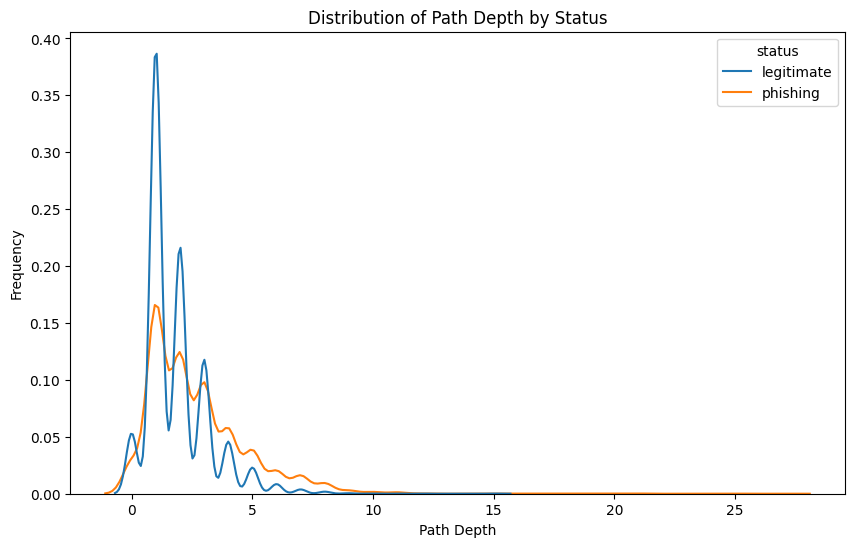

In [19]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='path_depth', hue='status')
plt.title("Distribution of Path Depth by Status")
plt.xlabel("Path Depth")
plt.ylabel("Frequency")
plt.show()

In [20]:
X = data.drop(['url', 'status'], axis=1)
y = LabelEncoder().fit_transform(data['status'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Identify feature types
numeric_features = [col for col in X.columns if col not in ['tld', 'file_extension']]
categorical_features = ['tld', 'file_extension']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='drop')

In [21]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    metrics = {}
    
    for set_name, X, y in [('Train', X_train, y_train), ('Test', X_test, y_test)]:
        preds = model.predict(X)
        proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X)
        
        metrics[f'{set_name} Accuracy'] = accuracy_score(y, preds)
        metrics[f'{set_name} F1'] = f1_score(y, preds)
        metrics[f'{set_name} Recall'] = recall_score(y, preds)
        metrics[f'{set_name} Precision'] = precision_score(y, preds)
        metrics[f'{set_name} ROC AUC'] = roc_auc_score(y, proba)
    
    return metrics

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
svm_pipe = Pipeline([
    ('pre', preprocessor),
    ('selector', feature_selection.SelectKBest(feature_selection.mutual_info_classif)),
    ('clf', svm.SVC(probability=True))
])

svm_params = {
    'selector__k': [10, 20],
    'clf__C': np.logspace(-1, 1, 5)
}

svm_search = RandomizedSearchCV(svm_pipe, svm_params, n_iter=50, scoring='roc_auc', n_jobs=-1)
svm_search.fit(X_train, y_train)
svm_metrics = evaluate_model(svm_search.best_estimator_, X_train, X_test, y_train, y_test)

In [24]:
svm_metrics

{'Train Accuracy': 0.8631889763779528,
 'Train F1': 0.856651770367824,
 'Train Recall': 0.8175853018372703,
 'Train Precision': 0.8996389891696751,
 'Train ROC AUC': np.float64(0.9405363077701463),
 'Test Accuracy': 0.8591426071741033,
 'Test F1': 0.8546931407942239,
 'Test Recall': 0.8285214348206474,
 'Test Precision': 0.8825722273998136,
 'Test ROC AUC': np.float64(0.9404515599154655)}

In [25]:
rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', ensemble.RandomForestClassifier())
])

rf_params = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

rf_search = GridSearchCV(rf_pipe, rf_params, scoring='roc_auc', n_jobs=-1)
rf_search.fit(X_train, y_train)
rf_metrics = evaluate_model(rf_search.best_estimator_, X_train, X_test, y_train, y_test)
rf_metrics

{'Train Accuracy': 0.9738626421697287,
 'Train F1': 0.9737333772942082,
 'Train Recall': 0.968941382327209,
 'Train Precision': 0.9785730064060084,
 'Train ROC AUC': np.float64(0.9956762567846125),
 'Test Accuracy': 0.9068241469816273,
 'Test F1': 0.9068648885002186,
 'Test Recall': 0.9072615923009624,
 'Test Precision': 0.9064685314685315,
 'Test ROC AUC': np.float64(0.9667403779252001)}

In [26]:
gb_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', ensemble.GradientBoostingClassifier())
])

gb_params = {
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': [3, 5],
    'clf__subsample': [0.8, 1.0]
}

gb_search = GridSearchCV(gb_pipe, gb_params, scoring='roc_auc', n_jobs=-1)
gb_search.fit(X_train, y_train)
gb_metrics = evaluate_model(gb_search.best_estimator_, X_train, X_test, y_train, y_test)
gb_metrics

{'Train Accuracy': 0.9230096237970253,
 'Train F1': 0.9215336602764155,
 'Train Recall': 0.9041994750656168,
 'Train Precision': 0.9395454545454546,
 'Train ROC AUC': np.float64(0.975590154112407),
 'Test Accuracy': 0.8985126859142607,
 'Test F1': 0.897887323943662,
 'Test Recall': 0.8923884514435696,
 'Test Precision': 0.9034543844109831,
 'Test ROC AUC': np.float64(0.9652098933827498)}

In [27]:
mlp_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', MLPClassifier(early_stopping=True, random_state=42))
])

mlp_params = {
    'clf__hidden_layer_sizes': [(50,), (100,), (50,50)],
    'clf__activation': ['relu', 'tanh', 'logistic'],
    'clf__batch_size': [64, 128],
}

mlp_search = RandomizedSearchCV(
    mlp_pipe,
    mlp_params,
    n_iter=50,
    scoring='roc_auc',
    n_jobs=-1,
    cv=3,
    random_state=42,
    verbose=1
)

mlp_search.fit(X_train, y_train)
mlp_metrics = evaluate_model(mlp_search.best_estimator_, X_train, X_test, y_train, y_test)
mlp_metrics

Fitting 3 folds for each of 18 candidates, totalling 54 fits


{'Train Accuracy': 0.9307742782152231,
 'Train F1': 0.9293920803123257,
 'Train Recall': 0.9111986001749781,
 'Train Precision': 0.9483268836785795,
 'Train ROC AUC': np.float64(0.9802426271519209),
 'Test Accuracy': 0.8937007874015748,
 'Test F1': 0.8936542669584245,
 'Test Recall': 0.8932633420822397,
 'Test Precision': 0.8940455341506129,
 'Test ROC AUC': np.float64(0.9591093873545771)}

In [28]:
def evaluate_nn(model, X_train, X_test, y_train, y_test, device='cpu'):
    model.eval()
    metrics = {}
    
    for set_name, X, y in [('Train', X_train, y_train), ('Test', X_test, y_test)]:
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(device)
            outputs = model(X_tensor)
            proba = outputs.cpu().numpy()
            preds = (proba > 0.5).astype(int)
            
        metrics[f'{set_name} Accuracy'] = accuracy_score(y, preds)
        metrics[f'{set_name} F1'] = f1_score(y, preds)
        metrics[f'{set_name} Recall'] = recall_score(y, preds)
        metrics[f'{set_name} Precision'] = precision_score(y, preds)
        metrics[f'{set_name} ROC AUC'] = roc_auc_score(y, proba)
    
    return metrics

In [29]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * ((input_size-3+1)//2), 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x).squeeze()
def train_model(model, X, y, epochs=200):
        model.train()
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters())
        
        X_tensor = torch.FloatTensor(X).to(device)
        y_tensor = torch.FloatTensor(y).to(device)
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()

In [30]:
X_train_processed = preprocessor.fit_transform(X_train).toarray()
X_test_processed = preprocessor.transform(X_test).toarray()

input_size = X_train_processed.shape[1]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn_model = CNN(input_size).to(device)
    
train_model(cnn_model, X_train_processed, y_train)
cnn_metrics = evaluate_nn(cnn_model, X_train_processed, X_test_processed, y_train, y_test, device)
cnn_metrics

{'Train Accuracy': 0.8320209973753281,
 'Train F1': 0.8234888531372099,
 'Train Recall': 0.7836832895888014,
 'Train Precision': 0.8675544794188862,
 'Train ROC AUC': np.float64(0.9154102791230273),
 'Test Accuracy': 0.8359580052493438,
 'Test F1': 0.8306997742663657,
 'Test Recall': 0.8048993875765529,
 'Test Precision': 0.8582089552238806,
 'Test ROC AUC': np.float64(0.9186401459222672)}

In [31]:
class RNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.rnn = nn.GRU(input_size, 64, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        _, hidden = self.rnn(x)
        return self.fc(hidden[-1]).squeeze()

In [32]:
X_train_processed = preprocessor.fit_transform(X_train).toarray()
X_test_processed = preprocessor.transform(X_test).toarray()

input_size = X_train_processed.shape[1]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
rnn_model = RNN(input_size).to(device)

train_model(rnn_model, X_train_processed, y_train, epochs=1000)
rnn_metrics = evaluate_nn(rnn_model, X_train_processed, X_test_processed, y_train, y_test, device)
rnn_metrics

{'Train Accuracy': 0.9297900262467191,
 'Train F1': 0.9287616511318242,
 'Train Recall': 0.9153543307086615,
 'Train Precision': 0.9425675675675675,
 'Train ROC AUC': np.float64(0.9817020220460195),
 'Test Accuracy': 0.8958880139982502,
 'Test F1': 0.8963414634146342,
 'Test Recall': 0.9002624671916011,
 'Test Precision': 0.8924544666088465,
 'Test ROC AUC': np.float64(0.9559810601102685)}

In [33]:
from sklearn.ensemble import StackingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
estimators = [
    ('svm', svm_search.best_estimator_),
    ('rf', rf_search.best_estimator_)
]

In [34]:
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    n_jobs=-1,
    passthrough=False
)

stacking_model.fit(X_train, y_train)
stacking_metrics = evaluate_model(stacking_model, X_train, X_test, y_train, y_test)


In [35]:
stacking_metrics

{'Train Accuracy': 0.9659886264216972,
 'Train F1': 0.965805387575591,
 'Train Recall': 0.9606299212598425,
 'Train Precision': 0.9710369223966394,
 'Train ROC AUC': np.float64(0.9945018423987465),
 'Test Accuracy': 0.905074365704287,
 'Test F1': 0.905446623093682,
 'Test Recall': 0.9090113735783028,
 'Test Precision': 0.9019097222222222,
 'Test ROC AUC': np.float64(0.9684714060786146)}

In [36]:
def print_results(res):
    for i in res:
        print(f"{i}: {res[i]}")

In [37]:
from sklearn.decomposition import PCA
pca_dimensions = [2, 3, 5, 10, 15]
X_train_processed = preprocessor.fit_transform(X_train).toarray()
X_test_processed = preprocessor.transform(X_test).toarray()
pca_results = {}

for n_components in pca_dimensions:
    print(f"\nTesting with PCA n_components = {n_components}")

    svm_pipe_pca = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('clf', svm.SVC(probability=True, random_state=42))
    ])

    rf_pipe_pca = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('clf', ensemble.RandomForestClassifier(random_state=42))
    ])

    estimators = [
        ('svm', svm_pipe_pca),
        ('rf', rf_pipe_pca)
    ]
    stacking_model_pca = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(),
        n_jobs=-1,
        passthrough=False
    )

    stacking_model_pca.fit(X_train_processed, y_train)
    
    metrics = evaluate_model(stacking_model_pca, X_train_processed, X_test_processed, y_train, y_test)
    pca_results[n_components] = metrics
    
    print(f"PCA n_components = {n_components} Metrics:")
    print_results(metrics)



Testing with PCA n_components = 2
PCA n_components = 2 Metrics:
Train Accuracy: 0.967082239720035
Train F1: 0.9674066053059015
Train Recall: 0.9770341207349081
Train Precision: 0.9579669740510401
Train ROC AUC: 0.9922915810337795
Test Accuracy: 0.7825896762904637
Test F1: 0.7817303469477382
Test Recall: 0.778652668416448
Test Precision: 0.7848324514991182
Test ROC AUC: 0.8559312303809794

Testing with PCA n_components = 3
PCA n_components = 3 Metrics:
Train Accuracy: 0.9850174978127734
Train F1: 0.9849533223503569
Train Recall: 0.9807524059492564
Train Precision: 0.9891903816457093
Train ROC AUC: 0.9955822280471722
Test Accuracy: 0.8035870516185477
Test F1: 0.8038444735692443
Test Recall: 0.8048993875765529
Test Precision: 0.8027923211169284
Test ROC AUC: 0.888234443135553

Testing with PCA n_components = 5
PCA n_components = 5 Metrics:
Train Accuracy: 0.9856736657917761
Train F1: 0.9856154606346766
Train Recall: 0.9816272965879265
Train Precision: 0.9896361631753032
Train ROC AUC: 0.

In [38]:
X_train_num = X_train[numeric_features]
X_test_num = X_test[numeric_features]

In [39]:
from sklearn.feature_selection import RFE
lr = LogisticRegression(max_iter=1000, random_state=42)

rfe_selector = RFE(estimator=lr, n_features_to_select=10)
rfe_selector.fit(X_train_num, y_train)

rfe_selected_features = X_train_num.columns[rfe_selector.support_]
print("RFE Selected Features:")
print(rfe_selected_features)

RFE Selected Features:
Index(['num_questionmark', 'num_at', 'num_exclamation', 'num_tilde',
       'num_plus', 'num_dollar', 'double_slash', 'phishy_words',
       'is_shortened', 'suspicious_tld'],
      dtype='object')


In [40]:
print("\nRFE Feature Rankings (lower is better):")
for feat, rank in zip(X_train_num.columns, rfe_selector.ranking_):
    print(f"{feat}: {rank}")


RFE Feature Rankings (lower is better):
url_length: 24
num_dots: 7
num_hyphens: 13
num_underscore: 10
num_slash: 11
num_questionmark: 1
num_equal: 8
num_at: 1
num_and: 12
num_exclamation: 1
num_space: 26
num_tilde: 1
num_comma: 14
num_plus: 1
num_asterisk: 4
num_hash: 20
num_dollar: 1
num_percent: 17
domain_length: 21
num_subdomains: 5
domain_has_ip: 22
is_https: 2
path_length: 23
num_params: 9
has_port: 19
double_slash: 1
phishy_words: 1
is_shortened: 1
num_digits: 18
domain_num_digits: 3
redirect_http: 16
suspicious_tld: 1
path_depth: 25
exe_extension: 15
is_ip: 6


In [41]:
X_train_fs = X_train_num[rfe_selected_features]
X_test_fs  = X_test_num[rfe_selected_features]

svm_estimator = svm.SVC(probability=True, random_state=42)
rf_estimator  = ensemble.RandomForestClassifier(random_state=42)

estimators = [
    ('svm', svm_estimator),
    ('rf',  rf_estimator)
]

stacking_model_fs = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42),
    n_jobs=-1,
    passthrough=False
)
stacking_model_fs.fit(X_train_fs, y_train)

StackingClassifier(estimators=[('svm', SVC(probability=True, random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42))],
                   final_estimator=LogisticRegression(random_state=42),
                   n_jobs=-1)

In [42]:
fs_metrics = evaluate_model(stacking_model_fs, X_train_fs, X_test_fs, y_train, y_test)
fs_metrics

{'Train Accuracy': 0.6811023622047244,
 'Train F1': 0.6001097092704334,
 'Train Recall': 0.4785651793525809,
 'Train Precision': 0.8044117647058824,
 'Train ROC AUC': np.float64(0.7006059459649784),
 'Test Accuracy': 0.6754155730533683,
 'Test F1': 0.5989189189189189,
 'Test Recall': 0.4846894138232721,
 'Test Precision': 0.7835926449787836,
 'Test ROC AUC': np.float64(0.6974968024010122)}

In [43]:
!pip install sklearn-genetic

In [44]:
results = {
    'SVM': svm_metrics,
    'RandomForest': rf_metrics,
    'GradientBoosting': gb_metrics,
    'MLP': mlp_metrics,
    'CNN': cnn_metrics,
    'RNN': rnn_metrics,
    'Stacking': stacking_metrics,
    'Feature Selection': fs_metrics,
}

models = []
accuracy = []
f1 = []
recall = []
precision = []
roc_auc = []

for name, metrics in results.items():
    models.append(name)
    accuracy.append(metrics.get('Test Accuracy'))
    f1.append(metrics.get('Test F1'))
    recall.append(metrics.get('Test Recall'))
    precision.append(metrics.get('Test Precision'))
    roc_auc.append(metrics.get('Test ROC AUC'))

In [45]:
df_results = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'F1 Score': f1,
    'Recall': recall,
    'Precision': precision,
    'ROC AUC': roc_auc
})

In [46]:
df_results

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC
0,SVM,0.859143,0.854693,0.828521,0.882572,0.940452
1,RandomForest,0.906824,0.906865,0.907262,0.906469,0.966740
2,GradientBoosting,0.898513,0.897887,0.892388,0.903454,0.965210
3,MLP,0.893701,0.893654,0.893263,0.894046,0.959109
4,CNN,0.835958,0.830700,0.804899,0.858209,0.918640
5,RNN,0.895888,0.896341,0.900262,0.892454,0.955981
6,Stacking,0.905074,0.905447,0.909011,0.901910,0.968471
7,Feature Selection,0.675416,0.598919,0.484689,0.783593,0.697497


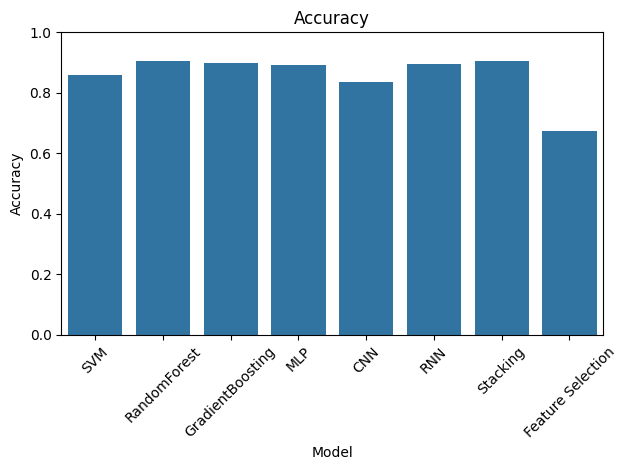

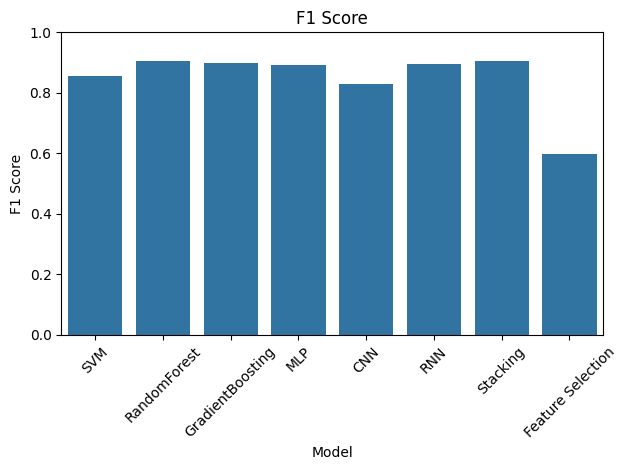

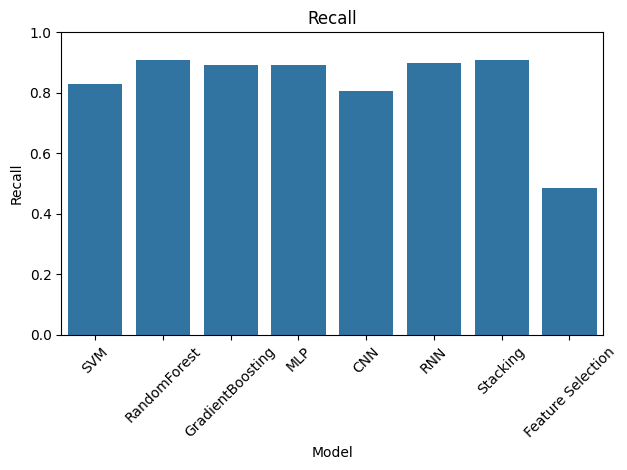

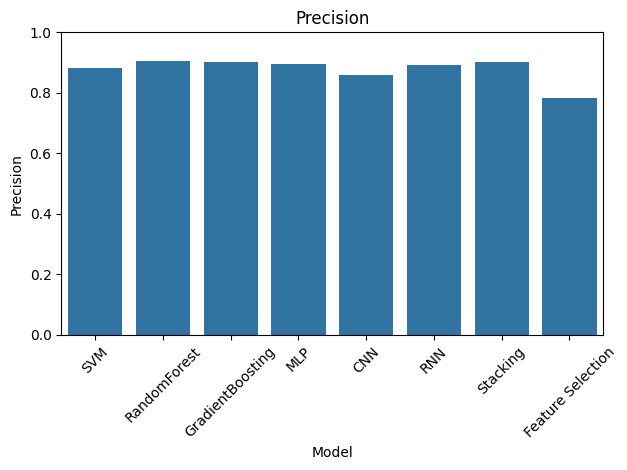

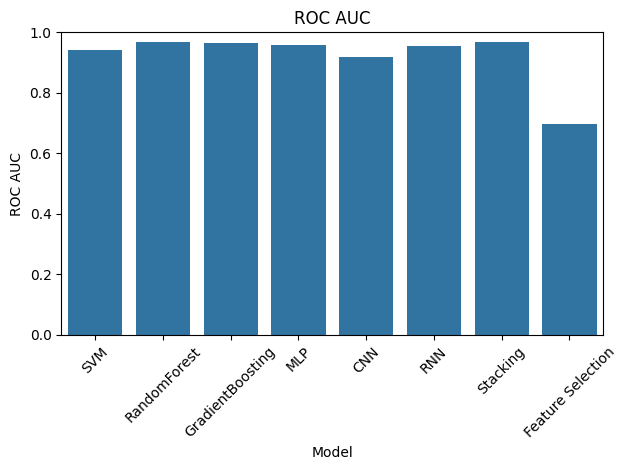

In [47]:
metrics_names = ['Accuracy', 'F1 Score', 'Recall', 'Precision', 'ROC AUC']
num_metrics = len(metrics_names)

for i, metric in enumerate(metrics_names):
    sns.barplot(x='Model', y=metric, data=df_results)
    plt.title(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


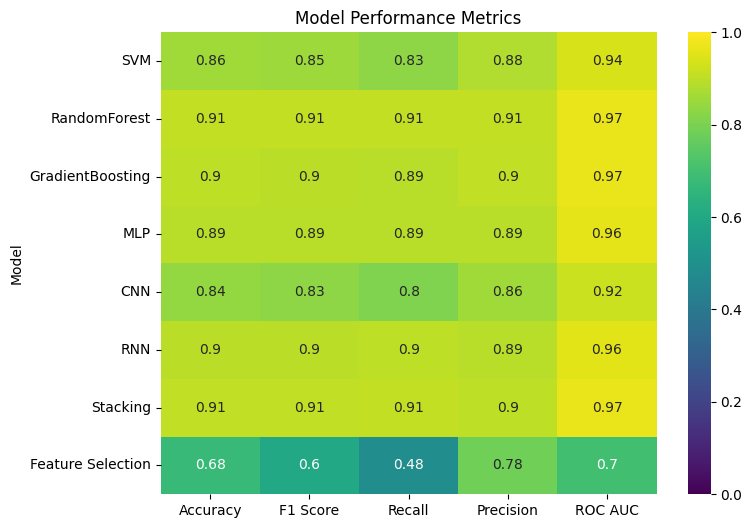

In [48]:
df_heatmap = df_results.set_index('Model')
plt.figure(figsize=(8, 6))
sns.heatmap(df_heatmap, annot=True, cmap="viridis", vmin=0, vmax=1)
plt.title("Model Performance Metrics")
plt.show()

In [49]:
import pickle
models = {
        'svm': svm_search.best_estimator_,
        'rf': rf_search.best_estimator_,
        'gb': gb_search.best_estimator_,
        'mlp': mlp_search.best_estimator_,
        'stacking': stacking_model,
        'fs': stacking_model_fs,
        'cnn': cnn_model,
        'rnn': rnn_model
    }
for key in models:
    with open(f'{key}.pkl', 'wb') as f:
        pickle.dump(models[key], f)


In [50]:
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [51]:
def predict_url(url, model_name):
    """
    Predicts whether a given URL is phishing or legitimate using the specified model.

    """
    features = {}
    features['url'] = url
    features['status'] = 'unknown'
    
    features = extract_features(features, url)
    features = add_advanced_features(features, url)
    
    input_df = pd.DataFrame([features])
    X_input = input_df.drop(['url', 'status'], axis=1)
    
    with open('preprocessor.pkl', 'rb') as f:
        preprocessor = pickle.load(f)
    pickle_filename = f"{model_name}.pkl"

    with open(pickle_filename, 'rb') as f:
        model = pickle.load(f)
    
    if model_name in ['cnn', 'rnn']:
        X_processed = preprocessor.transform(X_input).toarray()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X_processed).to(device)
            outputs = model(X_tensor)
            pred = (outputs.cpu().numpy() > 0.5).astype(int)
    elif model_name == 'fs':
        X_input_fs = X_input[rfe_selected_features]
        pred = model.predict(X_input_fs)[0]
    else:
        pred = model.predict(X_input)[0]
    return "Phishing" if pred == 1 else "Legitimate"

In [52]:
url_example = 'https://www.youtube.com/'
model_choice = "stacking"
result = predict_url(url_example, model_choice)
print(f"The URL is predicted to be: {result}")

The URL is predicted to be: Legitimate


In [53]:
url_example = 'http://www.budgetbots.com/server.php/Server%20update/index.php?email=USER@DOMAIN.com'
model_choice = "stacking"
result = predict_url(url_example, model_choice)
print(f"The URL is predicted to be: {result}")

The URL is predicted to be: Phishing


*GUI*

In [56]:
import tkinter as tk
from tkinter import ttk, scrolledtext, filedialog
import pickle
import pandas as pd
import torch

def predict_url(url, model_name):
    features = {'url': url, 'status': 'unknown'}
    features = extract_features(features, url)
    features = add_advanced_features(features, url)
    input_df = pd.DataFrame([features])
    X_input = input_df.drop(['url', 'status'], axis=1)
    with open('preprocessor.pkl', 'rb') as f:
        preprocessor = pickle.load(f)
    pickle_filename = f"{model_name}.pkl"
    with open(pickle_filename, 'rb') as f:
        model = pickle.load(f)
    if model_name in ['cnn', 'rnn']:
        X_processed = preprocessor.transform(X_input).toarray()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X_processed).to(device)
            outputs = model(X_tensor)
            pred = (outputs.cpu().numpy() > 0.5).astype(int)
    elif model_name == 'fs':
        X_input_fs = X_input[rfe_selected_features]
        pred = model.predict(X_input_fs)[0]
    else:
        pred = model.predict(X_input)[0]
    return "Phishing" if pred == 1 else "Legitimate"

model_names = ['svm', 'rf', 'gb', 'mlp', 'stacking', 'fs', 'cnn', 'rnn']

def run_predictions():
    url = url_entry.get().strip()
    if not url:
        result_text.delete(1.0, tk.END)
        result_text.insert(tk.END, "Please enter a URL.\n")
        return
    result_text.delete(1.0, tk.END)
    result_text.insert(tk.END, f"Prediction for URL: {url}\n")
    for name in model_names:
        try:
            prediction = predict_url(url, name)
            result_text.insert(tk.END, f"Model {name.upper()}: {prediction}\n")
        except Exception as e:
            result_text.insert(tk.END, f"Model {name.upper()}: error ({e})\n")
    result_text.insert(tk.END, "\n")

def run_excel_predictions():
    file_path = filedialog.askopenfilename(title="Select Excel file",
                                           filetypes=[("Excel files", "*.xlsx;*.xls")])
    if not file_path:
        return
    try:
        df = pd.read_excel(file_path)
    except Exception as e:
        result_text.delete(1.0, tk.END)
        result_text.insert(tk.END, f"Error reading file: {e}\n")
        return
    if 'urls' not in df.columns:
        result_text.delete(1.0, tk.END)
        result_text.insert(tk.END, "The file does not contain a 'urls' column.\n")
        return
    result_text.delete(1.0, tk.END)
    for url in df['urls']:
        if pd.isnull(url):
            continue
        result_text.insert(tk.END, f"Prediction for URL: {url}\n")
        for name in model_names:
            try:
                prediction = predict_url(url, name)
                result_text.insert(tk.END, f"  Model {name.upper()}: {prediction}\n")
            except Exception as e:
                result_text.insert(tk.END, f"  Model {name.upper()}: error ({e})\n")
        result_text.insert(tk.END, "\n")

root = tk.Tk()
root.title("ML Model: URL Evaluation")
root.geometry("600x500")
root.resizable(False, False)
input_frame = ttk.Frame(root, padding="10")
input_frame.pack(fill=tk.X)
url_label = ttk.Label(input_frame, text="Enter URL:")
url_label.pack(side=tk.LEFT, padx=(0, 10))
url_entry = ttk.Entry(input_frame, width=50)
url_entry.pack(side=tk.LEFT, fill=tk.X, expand=True)
predict_button = ttk.Button(input_frame, text="Evaluate URL", command=run_predictions)
predict_button.pack(side=tk.LEFT, padx=(10, 0))
excel_button = ttk.Button(input_frame, text="Load Excel", command=run_excel_predictions)
excel_button.pack(side=tk.LEFT, padx=(10, 0))
result_frame = ttk.Frame(root, padding="10")
result_frame.pack(fill=tk.BOTH, expand=True)
result_text = scrolledtext.ScrolledText(result_frame, wrap=tk.WORD, width=70, height=25)
result_text.pack(fill=tk.BOTH, expand=True)
root.mainloop()
